# Explorar, cargar y descargar datos satelitales


Por supuesto, con SPAI se puede explorar y descargar distintas colecciones y tipos de datos satelitales. Vamos a ver cómo explorar, cargar y descargar estos datos.

Antes de nada, un pequeño formulario. Podéis escanear el QR, responder aquí directamente o comentarlo en directo.

<div style="display: flex; justify-content: center;">
    <img src="../img/qr-acceso.png" width=350 height=350>
<iframe src="https://docs.google.com/forms/d/e/1FAIpQLScOEcnOxo7gUmqxKGek8XTA7Tzvwp8htXdmVhuwTFqKZg0TIQ/viewform?embedded=true" width="640" height="600" frameborder="0" marginheight="0" marginwidth="0">Cargando…</iframe>
</div>


Lo primero que podemos hacer es ver las colecciones de datos disponibles ahora mismo.

> ¡Estad atentos! Actualizamos nuestras colecciones de datos constantemente.


In [1]:
from spai.data.satellite import AVAILABLE_COLLECTIONS

AVAILABLE_COLLECTIONS

['sentinel-2-l2a',
 'sentinel-1-grd',
 'sentinel-1-rtc',
 'cop-dem-glo-30',
 'cop-dem-glo-90',
 'esa-worldcover',
 'landsat-8-c2-l2',
 'modis-burned-areas',
 'modis-snow-cover-8',
 'modis-snow-cover-daily',
 'alos-palsar-mosaic']

> SPAI utiliza diferentes clientes para acceder a los datos y las diferentes colecciones, según su origen. Por ejemplo, las colecciones de arriba se obtienen utilizando la API de [STAC](https://stacspec.org/en), pero otras colecciones que se añadirán pronto pueden venir de proveedores comerciales.


## Explorar imágenes disponibles


Ahora podemos explorar las imágenes disponibles en una zona. Lo que necesitamos para buscar, es lo siguiente:

- `aoi`: puede ser **_cualquier cosa relacionada con una geometría o un lugar_**, como el nombre de un lugar, una bounding box, una geometría o un GeoDataFrame.
- `date`: str, lista o objetos de fecha y hora. Puede ser una fecha única, como 2020-01-01, o un intervalo de tiempo, como (2020-01-01, 2020-01-10) o 2020-01-01/2020-01-10. Si no se proporciona, busca las imágenes disponibles en el último mes.
- `colection`: str. Una de las AVAILABLE_COLLECTIONS. Si no se proporciona, de forma predeterminada es `sentinel-2-l2a`.


In [2]:
from spai.data.satellite import explore_satellite_imagery

search = explore_satellite_imagery("Madrid")
print(len(search))
search[:3]

22


[{'id': 'S2A_30TVL_20240515_0_L2A',
  'datetime': '2024-05-15T11:19:51Z',
  'thumbnail': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/30/T/VL/2024/5/S2A_30TVL_20240515_0_L2A/thumbnail.jpg'},
 {'id': 'S2A_30TVK_20240515_0_L2A',
  'datetime': '2024-05-15T11:20:05Z',
  'thumbnail': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/30/T/VK/2024/5/S2A_30TVK_20240515_0_L2A/thumbnail.jpg'},
 {'id': 'S2B_30TVL_20240517_0_L2A',
  'datetime': '2024-05-17T11:09:50Z',
  'thumbnail': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/30/T/VL/2024/5/S2B_30TVL_20240517_0_L2A/thumbnail.jpg'}]

In [3]:
import datetime
from PIL import Image
from io import BytesIO
import requests

import matplotlib.pyplot as plt


def plot_thumbnail(search):
    fig, axes = plt.subplots(2, 3, figsize=(10, 6))

    for i, image in enumerate(search[:6]):
        response = requests.get(image["thumbnail"])
        img = Image.open(BytesIO(response.content))

        # Get the datetime from the image
        datetime_str = image["datetime"]
        datetime_obj = datetime.datetime.strptime(datetime_str, "%Y-%m-%dT%H:%M:%SZ")

        # Plot the image with datetime as title
        ax = axes[i // 3, i % 3]
        ax.imshow(img)
        ax.set_title(datetime_obj)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

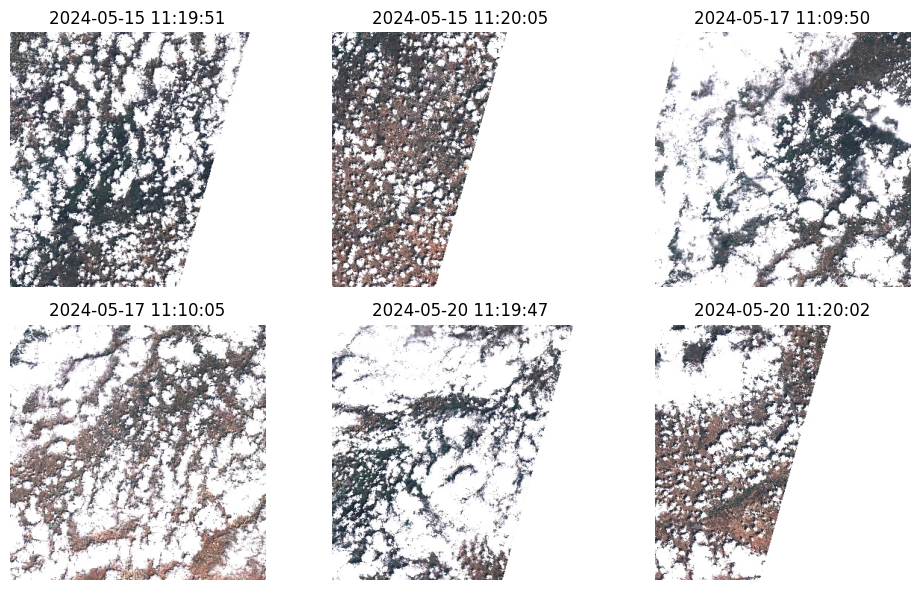

In [4]:
plot_thumbnail(search)

Como se ha dicho, también se puede probar con un GeoDataFrame de GeoPandas.


In [15]:
import geopandas as gpd
import leafmap

gdf = gpd.read_file("data/estany_ivars.geojson")
m = leafmap.Map()
m.add_gdf(gdf, "Ivars", zoom_to_layer=True)
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

In [16]:
search = explore_satellite_imagery(gdf, date="2020-01-01/2020-01-15")
search[:3]

[{'id': 'S2A_31TCG_20200101_0_L2A',
  'datetime': '2020-01-01T10:59:21Z',
  'thumbnail': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/31/T/CG/2020/1/S2A_31TCG_20200101_0_L2A/thumbnail.jpg'},
 {'id': 'S2A_31TCG_20200101_1_L2A',
  'datetime': '2020-01-01T10:59:21Z',
  'thumbnail': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/31/T/CG/2020/1/S2A_31TCG_20200101_1_L2A/thumbnail.jpg'},
 {'id': 'S2B_31TCG_20200106_0_L2A',
  'datetime': '2020-01-06T10:59:22Z',
  'thumbnail': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/31/T/CG/2020/1/S2B_31TCG_20200106_0_L2A/thumbnail.jpg'}]

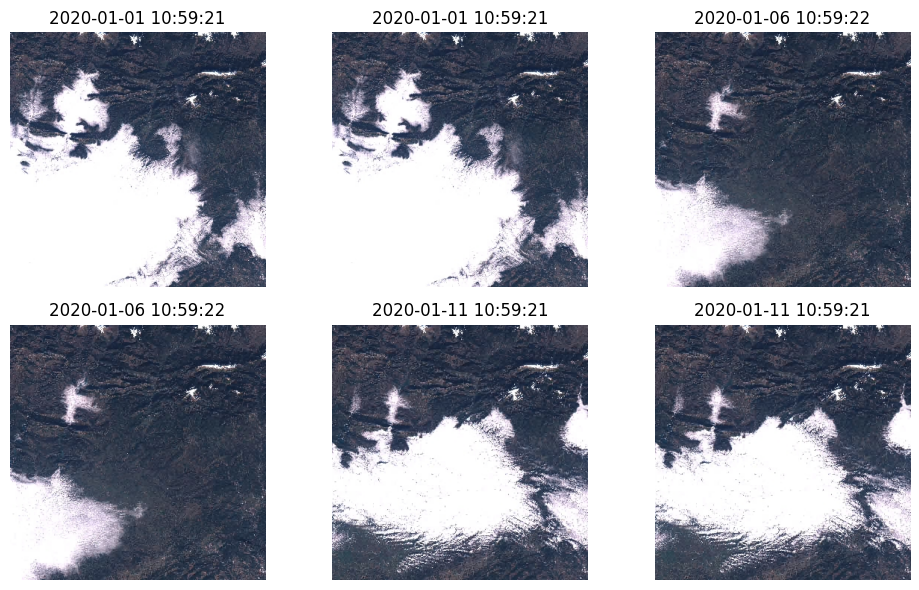

In [17]:
plot_thumbnail(search)

Como se puede ver, las imágenes tiene un alto porcentaje de cobertura de nubes. Por supuesto, podemos añadir parámetros extra a nuestra búsqueda, como por ejemplo `cloud_cover`, `vegetation_percentage`, etc. Además de otros parámetros de pre-procesado de los datos, como su `CRS`, resolución o bandas.


- `crs`: el `CRS` de los datos a recuperar.
- `resolution`: la resolución de los datos a recuperar. Debe estar en las unidades crs. ex. EPSG4326 está en grados, EPSG3857 en metros.
- `bands`: bandas para recuperar. De forma predeterminada, cada colección tiene bandas predeterminadas. p.ej. Sentinel-2-l2a tiene del 1 al 12 (costero, azul, verde...), o Sentinel-1-grd tiene vv y vh.
- Otros parámetros extra.

Para ver la lista de parámetros, bandas por defecto y demás información de las colecciones, podeis ir a la [referencia](https://spai.earthpulse.ai/docs/reference/lib/data-collections).


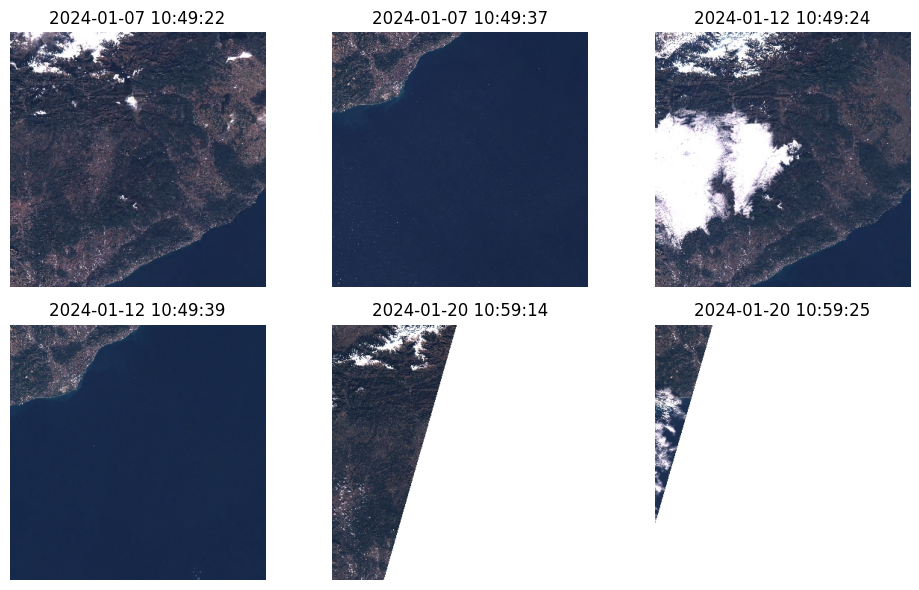

In [18]:
cloud_cover = 50
search = explore_satellite_imagery(
    "Barcelona", ("2024-01-01", "2024-02-01"), "sentinel-2-l2a", cloud_cover=cloud_cover
)
plot_thumbnail(search)

## Cargar imágenes en memoria


Los datos satelitales pueden llegar a ser muy grandes y consumir mucho en términos de espacio y recursos de computación. Con SPAI se pueden explorar y cargar los datos que necesitemos directamente en memoria, utilizando la librería `xarray`, y cargando los datos directamente como un `xr.Dataset`. Esto nos permite un manejo más eficiente de los datos.


In [19]:
from spai.data.satellite import load_satellite_imagery
import geopandas as gpd

gdf = gpd.read_file("data/estany_ivars.geojson")
bands = ["red", "green", "blue"]
data = load_satellite_imagery(
    gdf, date="2023-08-01/2023-08-30", bands=bands, cloud_cover=40
)
data

<xarray.Dataset>
Dimensions:      (latitude: 169, longitude: 402, time: 4)
Coordinates:
  * latitude     (latitude) float64 41.69 41.69 41.69 ... 41.68 41.67 41.67
  * longitude    (longitude) float64 0.9299 0.93 0.93 ... 0.9658 0.9659 0.966
    spatial_ref  int32 4326
  * time         (time) datetime64[ns] 2023-08-03T10:59:32.381000 ... 2023-08...
Data variables:
    red          (time, latitude, longitude) uint16 dask.array<chunksize=(4, 169, 402), meta=np.ndarray>
    green        (time, latitude, longitude) uint16 dask.array<chunksize=(4, 169, 402), meta=np.ndarray>
    blue         (time, latitude, longitude) uint16 dask.array<chunksize=(4, 169, 402), meta=np.ndarray>

Un `dataset` de `xarray` puede verse como una estructura de diccionario que contiene datos, dimensiones y atributos. Las variables en un objeto Dataset se denominan DataArrays y comparten dimensiones con el Dataset de nivel superior. La siguiente figura proporciona un ejemplo ilustrativo:

![Alt text](../img/xarray.png "xarray")


Para acceder a una variable podemos acceder como si fuera un diccionario de Python, o usando el archivo . notación, que es más conveniente.


In [20]:
data["red"]

<xarray.DataArray 'red' (time: 4, latitude: 169, longitude: 402)>
dask.array<red, shape=(4, 169, 402), dtype=uint16, chunksize=(4, 169, 402), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 41.69 41.69 41.69 ... 41.68 41.67 41.67
  * longitude    (longitude) float64 0.9299 0.93 0.93 ... 0.9658 0.9659 0.966
    spatial_ref  int32 4326
  * time         (time) datetime64[ns] 2023-08-03T10:59:32.381000 ... 2023-08...
Attributes:
    nodata:   0

Xarray ofrece dos formas diferentes de seleccionar datos. Esto incluye el enfoque isel(), donde los datos se pueden seleccionar en función de su índice (como numpy).


In [21]:
print(data.time.values)

sample_data = data.isel(time=0)
sample_data

['2023-08-03T10:59:32.381000000' '2023-08-13T10:59:32.369000000'
 '2023-08-23T10:59:33.323000000' '2023-08-28T10:59:31.715000000']


<xarray.Dataset>
Dimensions:      (latitude: 169, longitude: 402)
Coordinates:
  * latitude     (latitude) float64 41.69 41.69 41.69 ... 41.68 41.67 41.67
  * longitude    (longitude) float64 0.9299 0.93 0.93 ... 0.9658 0.9659 0.966
    spatial_ref  int32 4326
    time         datetime64[ns] 2023-08-03T10:59:32.381000
Data variables:
    red          (latitude, longitude) uint16 dask.array<chunksize=(169, 402), meta=np.ndarray>
    green        (latitude, longitude) uint16 dask.array<chunksize=(169, 402), meta=np.ndarray>
    blue         (latitude, longitude) uint16 dask.array<chunksize=(169, 402), meta=np.ndarray>

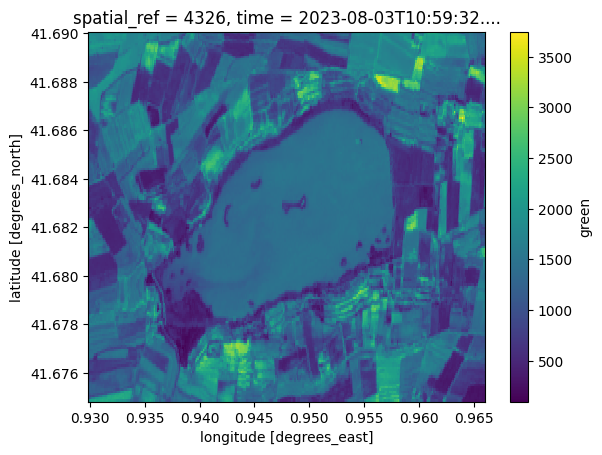

In [22]:
sample_data["green"].plot()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


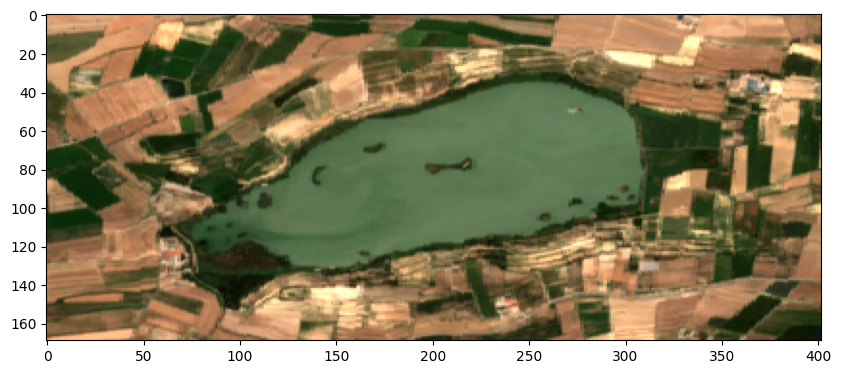

In [23]:
import numpy as np
import matplotlib.pyplot as plt

rgb = np.dstack(
    (
        sample_data.red.values,
        sample_data.green.values,
        sample_data.blue.values,
    )
)
rgb = rgb / 3000  # Eliminar outliers

plt.figure(figsize=(10, 8))
plt.imshow(rgb)
plt.show()

In [24]:
sar = load_satellite_imagery(
    gdf,
    ("2020-01-01", "2020-01-10"),
    "sentinel-1-grd",
)
sar

<xarray.Dataset>
Dimensions:      (latitude: 337, longitude: 803, time: 3)
Coordinates:
  * latitude     (latitude) float64 41.69 41.69 41.69 ... 41.67 41.67 41.67
  * longitude    (longitude) float64 0.9298 0.9299 0.9299 ... 0.9659 0.966
    spatial_ref  int32 4326
  * time         (time) datetime64[ns] 2020-01-04T17:47:06.815675 ... 2020-01...
Data variables:
    vv           (time, latitude, longitude) float32 dask.array<chunksize=(3, 337, 512), meta=np.ndarray>
    vh           (time, latitude, longitude) float32 dask.array<chunksize=(3, 337, 512), meta=np.ndarray>

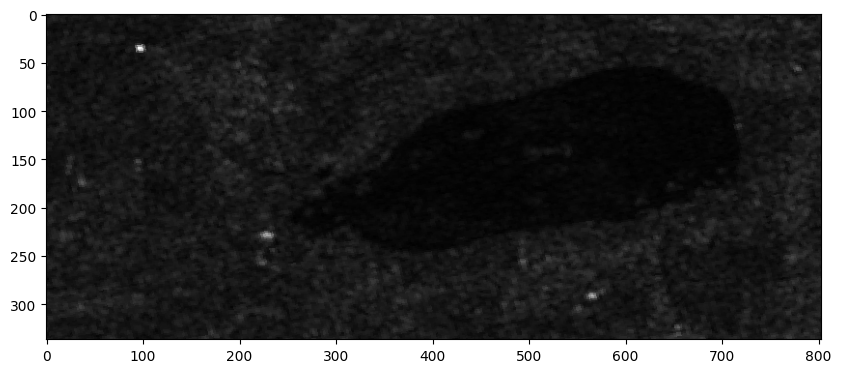

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(sar["vv"].isel(time=0), cmap="gray")
plt.show()

## Descargar imágenes en un Storage de SPAI


Por último, los datos pueden descargarse a un `Storage` de SPAI. Pero antes de nada, qué es un `Storage`?

Un `Storage` es una entidad de almacenamiento donde se guardarán nuestros datos y archivos, ya sean imágenes, analíticas, tablas y demás. Puede ser una entidad local en tu máquina o en la nube en un bucket de [S3](https://aws.amazon.com/es/s3/), y puede soportar varios tipos de archivos, desde formatos ráster en `tiff` o `png` hasta formatos tabulares o diccionarios en `csv`, `json`, `geojson`. Nuevos formatos, como `parquet` o `zarr`, se añadirán próximamente.

> Si quieres saber más, puedes ir a la [referencia](https://spai.earthpulse.ai/docs/reference/lib/storage).


In [26]:
from spai.storage.LocalStorage import LocalStorage

storage = LocalStorage("data")
storage.list()

'data' folder ready to use


['deep_globe.jpg', 'estany_ivars.geojson', 'SPOT_2022-10-20.tif']

> 💡 Utilizar un `Storage` de SPAI otorga diferentes ventajas, como por ejemplo la abstracción de los métodos para leer y guardar los datos, de manera que podemos utilizar las mismas funciones `read` o `create` independientemente de si utilizamos un `Storage` en local o en un bucket de S3. Además, si bien ahora solo dispone de clientes para almacenamientos en local o en un S3, en el futuro se añadirán nuevos clientes, por ejemplo para bases de datos (MongoDB, PostGIS) o para otros proveedores de almacenamiento, como Ellipsis Drive. Además, la potencia de esta clase sale a relucir especialmente cuando tratamos con datos en la nube, de manera que podemos manejar cómodamente nuestros archivos en un bucket de S3.


Ahora que hemos entendido lo que es un `Storage`, vamos a descargar algunas imágenes.

- `storage`: el almacenamiento donde se descargará la información.
- `name`: el nombre de la imagen o imágenes. Si es una sola imagen, es el nombre completo de la imagen. Por defecto es `collection_date`.
- `clip`: si el usuario desea recortar los datos a una geometría.
- Otros parámetros ya vistos como `aoi`, `datetime`, `resolution`, `query`, etc.


In [27]:
from spai.data.satellite import download_satellite_imagery

# This will download to the storage several images with the name given
dates = ["2023-07-09", "2023-07-14", "2023-07-19", "2023-07-29"]
for date in dates:
    download_satellite_imagery(
        storage,
        gdf,
        date=date,
        bands=["red", "green", "blue"],
        name=f"image_{date}.tif",
    )

In [28]:
storage.list()

['deep_globe.jpg',
 'image_2023-07-14.tif',
 'image_2023-07-29.tif',
 'estany_ivars.geojson',
 'image_2023-07-09.tif',
 'image_2023-07-19.tif',
 'SPOT_2022-10-20.tif']

In [29]:
path = storage.get_path("image_2023-07-09.tif")
path

'data/image_2023-07-09.tif'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


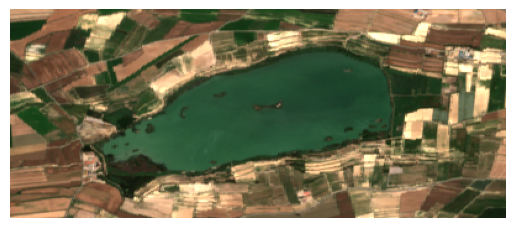

In [30]:
import xarray as xr
import matplotlib.pyplot as plt

data = xr.open_rasterio(path)

data = data / 3000
plt.imshow(data.transpose("y", "x", "band"))
plt.axis("off")
plt.show()